<a href="https://colab.research.google.com/github/IEXE-Tec/mcda-marketing/blob/main/02_metricas_segmentacion_ltv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

# Objetivo

+ ETL & EDA de los datos de retail
+ Segmentar Clientes
+ Calcular el Customer Life Time Value (LTV)

# ETL

## Importar Datos

In [ ]:
retail = pd.read_csv('https://github.com/IEXE-Tec/mcda-marketing/blob/main/OnlineRetail.csv.zip?raw=true', encoding='latin1',compression='zip')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## NaN, missing, infs

In [ ]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Columnas con NaNs

In [ ]:
retail.loc[:,retail.isna().any(axis=0)].head(2)

,Description,CustomerID
0,WHITE HANGING HEART T-LIGHT HOLDER,17850.0
1,WHITE METAL LANTERN,17850.0


Al parecer los nans solo estan las columnas de Description y CustomerID

### Rows con NaNs

In [ ]:
print('Total de rows con nans:  ', retail[retail.isna().any(axis=1)].shape[0])
retail[retail.isna().any(axis=1)].head(2)

Total de rows con nans:   135080


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom


#### NaNs en Description   


Observemos que hay muy pocos NaNs en la descripcion del producto

In [ ]:
retail[retail['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


Tambien obsrevamos que no tienen precio. Si bien seria conveniente investigar mas al respecto, por ahora podemos eliminarlos de la base, pues el porcentaje es pequeño y pueden complicar el analisis.

In [ ]:
retail[retail['Description'].isna()]['UnitPrice'].sum()

0.0

In [ ]:
retail = retail[~retail['Description'].isna()]

#### NaNs en CustomerID    



Hay muchos missings en el CustomerID alrededor del 20% de la base son NaNs. Esto puede deberse a un error en el sistema, o a que el comprador no creo una cuenta. 
+ Podriamos eliminarlos de la base, pero dado que representan alrededor del 20% es mejor quedarse con ellos.  
+ Podriamos crear un id especifico para todos estos compradores, por ejemplo un id negativo para al momento de modelar o manipular sea facil de recordar.

In [ ]:
retail[retail['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [ ]:
# Revisemos si fuera de los missings los ids son enteros o negativos
customer_id = retail.loc[~retail['CustomerID'].isna(), 'CustomerID'].unique()
customer_id = customer_id.astype(int)
(customer_id < 0).sum()

0

Podemos manejar los CustomerID como ints, y asignar el -1 a los clientes que no tienen ID sin problema, pues ningun otro tiene numero negativo.

In [ ]:
retail.loc[retail['CustomerID'].isna(), 'CustomerID'] = -1
retail['CustomerID'] = retail['CustomerID'].astype(int) 
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom


Como podemos obsrevar en la siguiente celda, no hay missings.

In [ ]:
retail[retail.isna().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


## Tipo de Datos

Convirtamos las columnas correspondientes a tipo fecha

In [ ]:
retail['date'] = pd.to_datetime(retail['InvoiceDate'])
# Creemos un time stampt para representar el mes y año (en este caso sera el fin de mes)
retail['year_month'] = retail['date'].map(lambda x: x.to_period('M').to_timestamp('M'))
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31


La columna de InvoiceNo no puede ser manejada directamente como entero, tiene que ser string. Podriamos hacer un diccionario de las columnas con strings a ints para mejorar el uso de memoria si asi lo desearamos.

In [ ]:
#retail['InvoiceNo'] = retail['InvoiceNo'].astype(int)

## Resumen ETL

Parece que los datos se encuentran en buen estado, salvo por los missings en el customer id que pueden deberse a varias causas y representan alrededor del 20% del total de la base. Para resolver el problema, les asignamos el numero -1.

# EDA Inicial

Recuerda que el objetivo es segmentar (clusterizar) a los clientes, pero tambien verificar la calidad de los datos pues es el primer EDA que realizamos sobre ellos.

Unas de las metricas mas importantes para el retail online :
+  **Ingresos Mensuales** o *monthly revenue*.

## EDA exploracion de datos

In [ ]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,540455.000000,540455.000000,540455.000000
mean,9.603129,4.623519,11507.604224
std,218.007598,96.889628,6761.212883
min,-80995.000000,-11062.060000,-1.000000
25%,1.000000,1.250000,12367.000000
50%,3.000000,2.080000,14390.000000
75%,10.000000,4.130000,16261.000000
max,80995.000000,38970.000000,18287.000000


Observemos como hay cantidades y precios negativos. Podrian ser devoluciones?

### Precio

In [ ]:
retail[retail['UnitPrice']<0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,-1,United Kingdom,2011-08-12 14:51:00,2011-08-31
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,-1,United Kingdom,2011-08-12 14:52:00,2011-08-31


Por el la descripcion podemos inferir que son ajustes de cuentas, dada la cantidad de ventas, podemos eliminarla sin causar mucho problema.

In [ ]:
retail = retail[~(retail['UnitPrice']<0.0)]

### Cantidad

In [ ]:
retail[retail['Quantity']<0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom,2010-12-01 09:41:00,2010-12-31
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom,2010-12-01 09:49:00,2010-12-31
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397,United Kingdom,2011-12-09 09:57:00,2011-12-31
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498,United Kingdom,2011-12-09 10:28:00,2011-12-31
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311,United Kingdom,2011-12-09 11:57:00,2011-12-31
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315,United Kingdom,2011-12-09 11:58:00,2011-12-31


En este caso parece que no hay algo que nos permita inferir que ocurrion, asi que podemos inferir que son **devoluciones**. Tambien puedes revisar la discusion en Kaggle: https://www.kaggle.com/vijayuv/onlineretail/discussion/130783 

### CustumerID

In [ ]:
print('Numero de clientes unicos:  ',len(retail['CustomerID'].unique()))

Numero de clientes unicos:   4373


### StockCode y Description

In [ ]:
print('Numero de StockCode unicos:  ',len(retail['StockCode'].unique()))

Numero de StockCode unicos:   3958


In [ ]:
print('Numero de Description unicos:  ',len(retail['Description'].unique()))

Numero de Description unicos:   4223


Podemos observar que el stockcode y la descripcion no tienen el mismo numero. Investiguiemos un poco mas.

In [ ]:
retail[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')

,StockCode,Description
31,10002,INFLATABLE POLITICAL GLOBE
103332,10080,GROOVY CACTUS INFLATABLE
454350,10080,check
5452,10120,DOGGY RUBBER
5451,10123C,HEARTS WRAPPING TAPE
...,...,...
228807,gift_0001_20,to push order througha s stock was
44725,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
38248,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
42057,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00


In [ ]:
r_ = retail[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')
r_[r_.duplicated(subset='StockCode', keep=False)]

,StockCode,Description
103332,10080,GROOVY CACTUS INFLATABLE
454350,10080,check
741,10133,COLOURING PENCILS BROWN TUBE
474647,10133,damaged
192289,15058A,wet/rusty
...,...,...
24906,DCGS0003,BOXED GLASS ASHTRAY
279254,DCGS0069,ebay
75053,DCGS0069,OOH LA LA DOGS COLLAR
44794,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00


Podemos observar como un solo StockCode (i.e. 10080) pertenece a varias descripciones. Por lo anterior conviene utilizar description como producto de venta, en especial para nuestra primera iteracion. Despues podriamos crear un diccionario o tabla que arregle estos problemas.

**Nota**: Al parecer los productos que estan escritos con letra minuscula son 'raros' o anomalos. Por ejemplo tienen adjetivos (wet/rusty), son vouchers de regalo (Dotcomgiftshop Gift Voucher £20.00), o cosas variadas (to push order througha s stock was). Tambien podriamos limpiar los datos de estos productos, pero dada la pequeña cantidad que representan y ser nuestra primera iteracion lo podemos obviar.

### InvoiceNo

InvoiceNo es el numero de compra o de transaccion, de manera que una persona que compra varios productos, pero en una sola compra los veremos bajo el mismo InvoiceNo. Esto lo inferimos de los snippets de codigo, y de una busqueda en google (https://dictionary.cambridge.org/us/dictionary/english/invoice).

In [ ]:
print('Numero de InvoiceNo unicos:  ',len(retail['InvoiceNo'].unique()))

Numero de InvoiceNo unicos:   24444


In [ ]:
retail[['InvoiceNo', 'CustomerID', 'Description']].sort_values('InvoiceNo')

,InvoiceNo,CustomerID,Description
0,536365,17850,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,17850,WHITE METAL LANTERN
2,536365,17850,CREAM CUPID HEARTS COAT HANGER
3,536365,17850,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,17850,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...
540449,C581490,14397,ZINC T-LIGHT HOLDER STARS SMALL
541541,C581499,15498,Manual
541715,C581568,15311,VICTORIAN SEWING BOX LARGE
541716,C581569,17315,HANGING HEART JAR T-LIGHT HOLDER


### Fecha

In [ ]:
print('Min date ',retail['date'].min())
print('Max date  ', retail['date'].max())

Min date  2010-12-01 08:26:00
Max date   2011-12-09 12:50:00


Podemos observar que los datos corresponden a poco mas de un año, dado que el ultimo mes no esta completo y probablemente hagamos agregaciones a nivel mensula conviene quitarlo para evitar confusiones.  
**Nota**: Podriamos agregar el corte en la aprte de ETL o aqui.

In [ ]:
retail = retail[retail['date'] < pd.to_datetime('2011-12-01')]

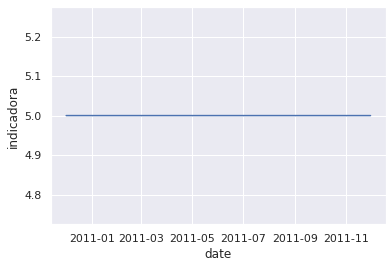

In [ ]:
fechas = retail[['date']].drop_duplicates()
fechas['indicadora'] = 5
sns.lineplot(data=fechas, x='date', y='indicadora')

### Country

## EDA Metricas

### Pais  
Esto realmente tebdria que ir en el ETL, pero dado que queriamos entender de manera general el contenido de las columans, preferimos analizarlo asi.

Para facilitar el analisis nos concentraremos en UK unicamente, pues es el que tiene mas datos (ve las siguientes celdas)

In [ ]:
retail['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [ ]:
retail[['Country', 'InvoiceNo']].drop_duplicates().groupby('Country', as_index=False)['InvoiceNo'].count().sort_values('InvoiceNo', ascending=False)

,Country,InvoiceNo
36,United Kingdom,21131
14,Germany,581
13,France,440
10,EIRE,348
3,Belgium,114
31,Spain,102
24,Netherlands,98
33,Switzerland,74
0,Australia,69
27,Portugal,66


In [ ]:
print(retail.shape)
retail = retail[retail['Country']=='United Kingdom']
print(retail.shape)

(514943, 10)
(470111, 10)


### **Tarea**

Parte de la tarea-evaluacion tendra que ver con estas metricas. Asegurate de entenderlas bien de manera intuitiva y practica!

### Revenue

In [ ]:
retail['revenue'] =  retail['UnitPrice'] * retail['Quantity']
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34


### Monthly Revenue

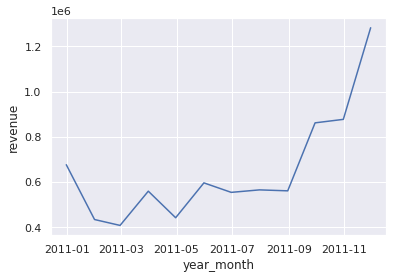

In [ ]:
mrevenue = retail.groupby('year_month', as_index=False)['revenue'].sum().sort_values('year_month', ascending=True)
sns.lineplot(data=mrevenue, x='year_month', y='revenue')

### Monthly Revenue Growth

Veamos cuanto han crecido las ventas mes a mes, esto nos puede ayudar a detectar patrones o anomalias.

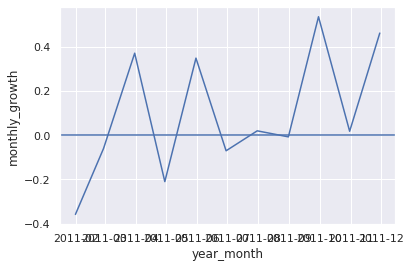

In [ ]:
mrevenue['monthly_growth'] = mrevenue['revenue'].pct_change()
g = sns.lineplot(data=mrevenue, x='year_month', y='monthly_growth')
g.axhline(0.0)

### Monthly Orders

Veamos cuantas compras/ordenes se hacen por mes

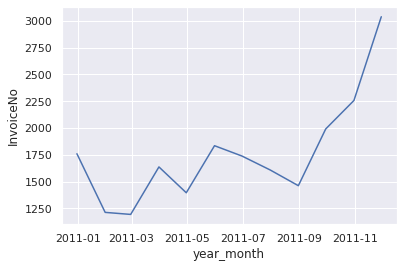

In [ ]:
morders = retail[['year_month','InvoiceNo']].drop_duplicates().groupby('year_month', 
        as_index=False)['InvoiceNo'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='InvoiceNo')

### Monthly Quantity

Ahora veamos cuantos articulos se venden por mes

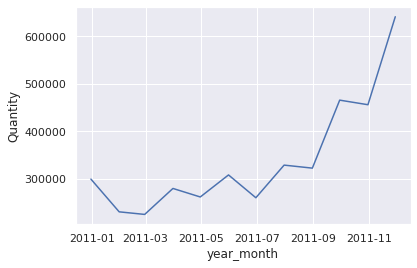

In [ ]:
morders = retail[['year_month','Quantity']].groupby('year_month', 
        as_index=False)['Quantity'].sum().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='Quantity')

### Monthly Active Custumers

In [ ]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34


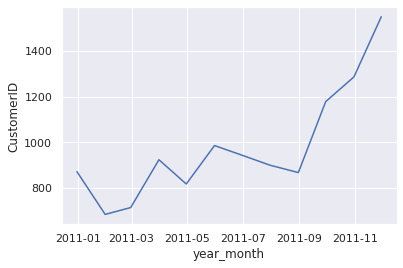

In [ ]:
mcustomer = retail[['year_month','CustomerID']].drop_duplicates().groupby('year_month', 
        as_index=False)['CustomerID'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=mcustomer, x='year_month', y='CustomerID')

### Monthly Customer Growth

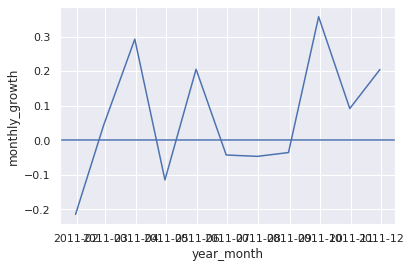

In [ ]:
mcustomer = mcustomer.sort_values('year_month', ascending=True)
mcustomer['monthly_growth'] = mcustomer['CustomerID'].pct_change()
g = sns.lineplot(data=mcustomer, x='year_month', y='monthly_growth')
g.axhline(0.0)

### Monthly Avg Revenue per Order

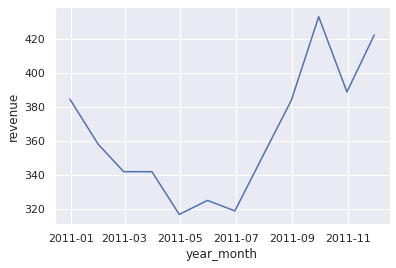

In [ ]:
rorder = retail[['year_month', 'InvoiceNo', 'revenue']]
# Colapsamos el revenue por Orden (InvoiceNo)
rorder = rorder.groupby(['year_month', 'InvoiceNo'], as_index=False)['revenue'].sum()
# Promedio por orden
rorder = rorder.groupby('year_month', as_index=False)['revenue'].mean()
sns.lineplot(data=rorder, x='year_month', y='revenue')

In [ ]:
rorder.describe()

,revenue
count,12.000000
mean,363.866436
std,38.765721
min,316.800889
25%,337.694391
50%,354.746385
75%,385.575400
max,432.957384


Por ahora, solo hemos utilizado recursos graficos, pero recuerda que existe el metodo `.describe()`. Observa como la compra promedio por mes es bastante estable

### Monthly Retention Rate

**Monthly Retention Rate**:= Cuantos clientes (customers) que estuvieron activos el mes pasado siguieron activos el siguiente mes.

`crosstab`:= https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

In [ ]:
crevenue = retail.sort_values('year_month', ascending=True).groupby(['CustomerID','year_month'], as_index=False)['revenue'].sum()
retention = pd.crosstab(crevenue['CustomerID'], crevenue['year_month']).reset_index()
retention.head()

year_month,CustomerID,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00
0,-1,1,1,1,1,1,1,1,1,1,1,1,1
1,12346,0,1,0,0,0,0,0,0,0,0,0,0
2,12747,1,1,0,1,0,1,1,0,1,0,1,1
3,12748,1,1,1,1,1,1,1,1,1,1,1,1
4,12749,0,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
### Loop para calcular la metrica
mes = retention.columns[2:]
retention_df = []
for m in range(len(mes)-1):
    retention_ = {}
    mes_actual = mes[m+1]
    mes_anterior = mes[m]
    retention_['year_month'] = mes_actual
    retention_['total_users'] = retention[mes_actual].sum()
    retention_['users_retained'] = retention[(retention[mes_actual]>0) & 
                                (retention[mes_anterior]>0)][mes_actual].sum()
    retention_df.append(retention_)
retention_df = pd.DataFrame(retention_df)

### Creamos la Metrica
retention_df['retention_rate'] = retention_df['users_retained']/retention_df['total_users']
retention_df.head()

,year_month,total_users,users_retained,retention_rate
0,2011-02-28,715,264,0.369231
1,2011-03-31,924,306,0.331169
2,2011-04-30,818,311,0.380196
3,2011-05-31,986,370,0.375254
4,2011-06-30,944,418,0.442797


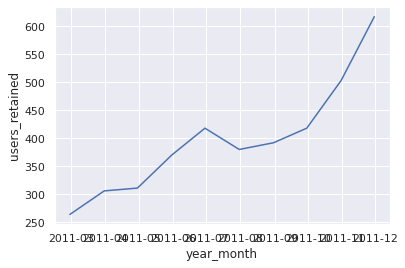

In [ ]:
sns.lineplot(data=retention_df, x='year_month', y='users_retained')

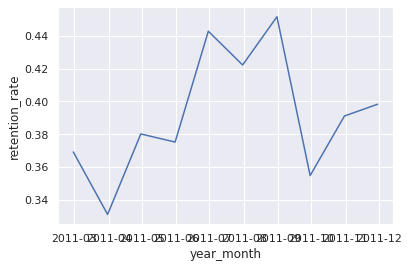

In [ ]:
sns.lineplot(data=retention_df, x='year_month', y='retention_rate')

### Cohort Initial Retention Rate (Tarea)

**Tarea**  
Entender el funcionamiento de los siguientes snippets de codigo

**Cohort Initial Retention Rate**:= Numero de usuarios retenidos despues de su primera compra (por mes).  
Cuantos usuarios compran el siguiente mes, dado que su primera compra fue el mes anterior.

La siguiente celda esta basada en codigo de: https://stackoverflow.com/questions/20069009/pandas-get-topmost-n-records-within-each-group 
revisa la fuente para entender mejor su funcionamiento.  



In [ ]:
# Meses en los que puede ocurrir la siguiente compra para considerarse retenido
cohort = 1
# Fecha de Primera Compra
primera_compra = crevenue.groupby('CustomerID', as_index=False)['year_month'].min()
primera_compra.rename(columns={'year_month':'cohort_begg'},inplace=True)

cohort_retention = crevenue.sort_values('year_month', ascending=True).groupby(
    'CustomerID').head(cohort + cohort).sort_values(['CustomerID','year_month'])
cohort_retention = cohort_retention[['CustomerID', 'year_month']]
# Quedarse solo con las fechas de compra dentro de la venta del cohort
cohort_retention = cohort_retention.merge(primera_compra, on='CustomerID')
cohort_retention['cohort_end'] = cohort_retention['cohort_begg'] + pd.DateOffset(months=cohort)
cohort_retention = cohort_retention[cohort_retention['year_month'] <= cohort_retention['cohort_end']]
# Detectar retenidos
compradores = cohort_retention.groupby(['CustomerID'], as_index=False)['year_month'].count()
retenidos_cohort = compradores[compradores['year_month']>1]
# Crear df con la ventana del cohort
total_retenidos = retenidos_cohort['CustomerID'].shape[0] / compradores['CustomerID'].shape[0]
total_retenidos

0.1792187898902221

Si el valor de `year_month` en la siguiente celda es mayor a uno significa que el cliente compro denuevo en los siguientes n-meses (cohort), por lo que se considera retenido.

In [ ]:
cohort_mes = []
# Fecha de Primera Compra
primera_compra = crevenue.groupby('CustomerID', as_index=False)['year_month'].min()
primera_compra.rename(columns={'year_month':'cohort_begg'},inplace=True)
for c in range(1,12):
  cohort_retention = crevenue.sort_values('year_month', ascending=True).groupby(
    'CustomerID').head(cohort + c).sort_values(['CustomerID','year_month'])
  cohort_retention = cohort_retention[['CustomerID', 'year_month']]
  # Quedarse solo con las fechas de compra dentro de la venta del cohort
  cohort_retention = cohort_retention.merge(primera_compra, on='CustomerID')
  cohort_retention['cohort_end'] = cohort_retention['cohort_begg'] + pd.DateOffset(months=c)
  cohort_retention = cohort_retention[cohort_retention['year_month'] <= cohort_retention['cohort_end']]
  # Detectar retenidos
  compradores = cohort_retention.groupby(['CustomerID'], as_index=False)['year_month'].count()
  retenidos_cohort = compradores[compradores['year_month']>1]
  # Crear df con la ventana del cohort
  total_retenidos = retenidos_cohort['CustomerID'].shape[0] / compradores['CustomerID'].shape[0]
  df_ = pd.DataFrame({'cohort':[c], 'retencion':[total_retenidos]})
  cohort_mes.append(df_)

cohort_mes = pd.concat(cohort_mes, ignore_index=True)
cohort_mes

,cohort,retencion
0,1,0.179219
1,2,0.349502
2,3,0.421241
3,4,0.481491
4,5,0.531785
5,6,0.558591
6,7,0.578504
7,8,0.591779
8,9,0.602757
9,10,0.612714


Ahora modifiquemos lo anterior, de manera que para cada mes la ventana se vaya moviendo, utilizando `crosstab`.

In [ ]:
# cambiemos las fechas de mes y año por un identificador numerico
crevenue['mes_int'] = crevenue['year_month'].apply(lambda x: x.year*100 + x.month)
crevenue['mes_int'].unique()

array([201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107,
       201108, 201109, 201110, 201111])

In [ ]:
# Usemos crosstab para manipular el dataframe
df_retention = pd.crosstab(crevenue['CustomerID'], crevenue['mes_int']).reset_index()
# Fecha de Primera compra por cliente
first_purchase = crevenue.groupby('CustomerID',as_index=False)['mes_int'].min()
first_purchase.rename(columns={'mes_int':'first_purchase'}, inplace=True)
# Crear tabla indicadora de compras por cliente, y mes(columnas)
df_retention = pd.merge(df_retention,first_purchase[['CustomerID','first_purchase']],on='CustomerID')
cols = list(df_retention.columns[:-1])
cols.append('first_purchase')
df_retention.columns = cols
df_retention

,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,first_purchase
0,-1,1,1,1,1,1,1,1,1,1,1,1,1,201012
1,12346,0,1,0,0,0,0,0,0,0,0,0,0,201101
2,12747,1,1,0,1,0,1,1,0,1,0,1,1,201012
3,12748,1,1,1,1,1,1,1,1,1,1,1,1,201012
4,12749,0,0,0,0,0,1,0,0,1,0,0,1,201105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,18280,0,0,0,1,0,0,0,0,0,0,0,0,201103
3913,18281,0,0,0,0,0,0,1,0,0,0,0,0,201106
3914,18282,0,0,0,0,0,0,0,0,1,0,0,0,201108
3915,18283,0,1,1,0,1,1,1,1,0,1,1,1,201101


In [ ]:
# Iteremos sobre una ventana de cada mes, similar a als metricas 
# y secciones anteriores.
meses = df_retention['first_purchase'].sort_values().unique()
retention_cohort = []
for m, _ in enumerate(meses):
    retention_ = {}
    selected_month = meses[m]
    mes_actual = meses[m]
    meses_anteriores = meses[:m]
    meses_siguientes = meses[m+1:]

    # Llenar de nans los meses anteriores, pues nadie compra antes de su primera compra
    for prev_month in meses_anteriores:
        retention_[prev_month] = np.nan
        
    usuarios_nuevos = df_retention[df_retention['first_purchase'] ==  int(mes_actual)]['first_purchase'].count()
    retention_['usuarios_nuevos'] = usuarios_nuevos
    retention_[mes_actual] = 1 
    
    query = "first_purchase == {}".format(mes_actual)
    

    for mes_siguiente in meses_siguientes:
        query_ = query + " and {} > 0".format(mes_siguiente)
        retention_[mes_siguiente] = df_retention.query(query_)[mes_siguiente].sum()/usuarios_nuevos
    
    retention_cohort.append(retention_)
    
retention_cohort = pd.DataFrame(retention_cohort)
retention_cohort.index = meses

#showing new cohort based retention table
retention_cohort

,usuarios_nuevos,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111
201012,872,1.0,0.370413,0.334862,0.378440,0.354358,0.396789,0.376147,0.349771,0.352064,0.397936,0.368119,0.493119
201101,362,NaN,1.000000,0.232044,0.279006,0.245856,0.342541,0.292818,0.262431,0.259669,0.314917,0.350829,0.361878
201102,339,NaN,NaN,1.000000,0.250737,0.191740,0.280236,0.283186,0.253687,0.259587,0.283186,0.277286,0.312684
201103,408,NaN,NaN,NaN,1.000000,0.193627,0.262255,0.215686,0.232843,0.171569,0.262255,0.237745,0.291667
201104,276,NaN,NaN,NaN,NaN,1.000000,0.224638,0.221014,0.217391,0.206522,0.231884,0.231884,0.264493
201105,252,NaN,NaN,NaN,NaN,NaN,1.000000,0.230159,0.170635,0.170635,0.214286,0.238095,0.265873
201106,207,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.212560,0.164251,0.246377,0.256039,0.323671
201107,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.203488,0.191860,0.232558,0.279070
201108,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.264286,0.228571,0.257143
201109,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.290909,0.327273


En esta caso vemos la tasa de retencion por mes de compra inicial.

# Segmentacion RMF

En esta parte de la clase segmentaremos a los usuarios basandonos en la metodologia RMF. Tambien podemos aplicar una varaicion, donde en vez de estimar por rango de cada variable R-M-F, utilizamos k-means sobre las tres variables normalizadas.

## EDA RMF

### Recency

Recency:= **Llena con tu definicion de Recency**

In [146]:
recency = retail[['CustomerID', 'year_month']].groupby('CustomerID', as_index=False).max()
recency

,CustomerID,year_month
0,-1,2011-11-30
1,12346,2011-01-31
2,12747,2011-11-30
3,12748,2011-11-30
4,12749,2011-11-30
...,...,...
3912,18280,2011-03-31
3913,18281,2011-06-30
3914,18282,2011-08-31
3915,18283,2011-11-30
